----
## Capstone Project
 - 1.Introduction
     - 1.1 Background Information
     - 1.2 Problem Statement
     - 1.3 Projet Origins
     - 1.4 Metrics
     - 1.5 Dataset


 - 2.Analysis
     - 2.1 Data Exploration
     - 2.2 Exploratory Visualization
     - 2.3 Algorithms and Methodology
         - Linear Regression
         - K-Nearest Neighbors
         - Support Vector Machine
     - 2.4 Benchmark
     
     
 - 3.Methodology
     - 3.1 Data Preprocessing
     - 3.2 Implementation
     - 3.3 Refinement
 
 
 - 4.Results
     - 4.1 Model Evaluation and Metrics
     - 4.2 (Justification)
 
 
 - 5.Conclusion
     - 5.1 Free-Form Visulization
     - 5.2 Improvements

---
## 0. Set up environemnt

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import seaborn as sns
sns.set_style('white')
%matplotlib inline 

# Import customized helper functions
from helper import symbol_to_path, get_data, plot_data, plot_selected
from daily_returns import compute_daily_returns

# Import sklearn 
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split


### 2.1 Data Exploration

In [245]:
df_SPY = pd.read_csv('Dataset/SPY.csv')
print 'First 5 rows of the dataset:'
df_SPY.head(n=5)

First 5 rows of the dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.9687,43.9687,43.7500,43.9375,27.466780,1003200
1,1993-02-01,43.9687,44.2500,43.9687,44.2500,27.662146,480500
2,1993-02-02,44.2187,44.3750,44.1250,44.3437,27.720715,201300
3,1993-02-03,44.4062,44.8437,44.3750,44.8125,28.013771,529400
4,1993-02-04,44.9687,45.0937,44.4687,45.0000,28.130983,531500


In [246]:
print 'Information about the data:'
df_SPY.info()

Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6301 entries, 0 to 6300
Data columns (total 7 columns):
Date         6301 non-null object
Open         6301 non-null float64
High         6301 non-null float64
Low          6301 non-null float64
Close        6301 non-null float64
Adj Close    6301 non-null float64
Volume       6301 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 344.7+ KB


In [247]:
print 'Number of missing values in each column:'
pd.isnull(df_SPY).sum()

Number of missing values in each column:


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [248]:
print 'Statistics of the dataset:'
df_SPY.describe()

Statistics of the dataset:


,Open,High,Low,Close,Adj Close,Volume
count,6301.000000,6301.000000,6301.000000,6301.000000,6301.000000,6.301000e+03
mean,125.935800,126.675043,125.107522,125.931212,104.406346,8.406350e+07
std,50.526929,50.648121,50.383799,50.530478,54.594421,1.005090e+08
min,43.343700,43.531200,42.812500,43.406200,27.134647,5.200000e+03
25%,94.500000,95.375000,93.500000,94.375000,70.730179,6.280900e+06
50%,121.500000,122.320000,120.779999,121.519997,94.472298,5.406440e+07
75%,145.440002,146.149994,144.149994,145.169998,119.688576,1.248421e+08
max,285.929993,286.579987,284.500000,286.579987,286.579987,8.710263e+08


In [45]:
df_Apple = pd.read_csv('Dataset/AAPL.csv')
df_Apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 7 columns):
Date         9379 non-null object
Open         9376 non-null float64
High         9376 non-null float64
Low          9376 non-null float64
Close        9376 non-null float64
Adj Close    9376 non-null float64
Volume       9376 non-null float64
dtypes: float64(6), object(1)
memory usage: 513.0+ KB


### 2.2 Exploratory Visualization

#### 2.2.1 Normal Prices (Without BRK-A)

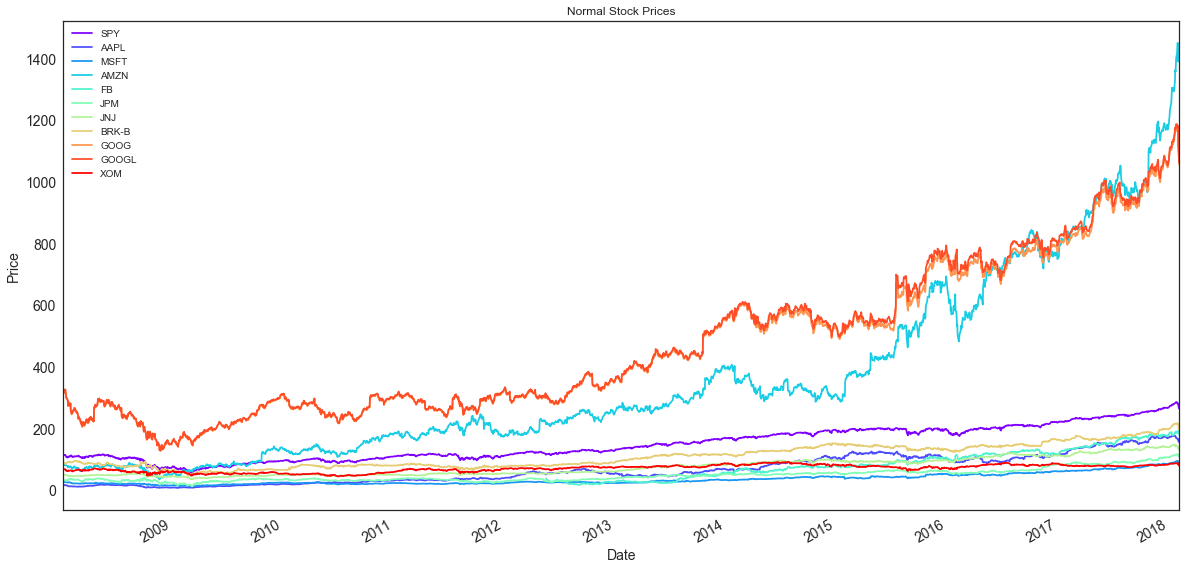

In [44]:
def symbol_to_path(symbol):
    # Return CSV file path given ticker symbol
    return os.path.join("Dataset/{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    
    # Read stock data(adjusted close) for given symbols from CSV files
    df = pd.DataFrame(index = dates)
    if 'SPY' not in symbols: # add SPY for reference, if absent
        symbols.insert(0,'SPY')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates = True, usecols = ['Date', 'Adj Close'], na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp)
        # Drop dates SPY did not trade
        if symbol == 'SPY':
            df = df.dropna(subset=['SPY'])
        # THIS!!! It took me 4 days to figure out.
        df[symbol] = pd.to_numeric(df[symbol], errors = 'coerce')
    return df


def plot_data(df, title):
    
    # Plot stock 
    ax = df.plot(title='Normal Stock Prices', fontsize=14,figsize = [20,10], colormap='rainbow')
    ax.set_xlabel('Date',fontsize=14)
    ax.set_ylabel('Price',fontsize=14)
    plt.show()
    
def plot_selected(df, columns, start_index, end_index):
    '''Plot the desire columns over desire dates'''
#     df = normalize_data(df)
    plot_data(df.loc[start_index:end_index, columns], title= 'SPY and its top 10 weighted stocks')
    df = df.loc[start_index:end_index, columns]
    

    
def test_run():
    
    # Define a date range
    dates = pd.date_range('2008-01-05', '2018-02-14')
    
    # Choose stock symbol to read
    symbols = ['SPY','AAPL','MSFT','AMZN','FB','JPM','JNJ','BRK-B','GOOG','GOOGL','XOM' ]

    # Get stock data
    df = get_data(symbols, dates)
    
    # Plot them out
    plot_selected(df, symbols, dates[0], dates[-1])

if __name__=='__main__':
    test_run()
    

#### 2.2.3 Normalized Prices

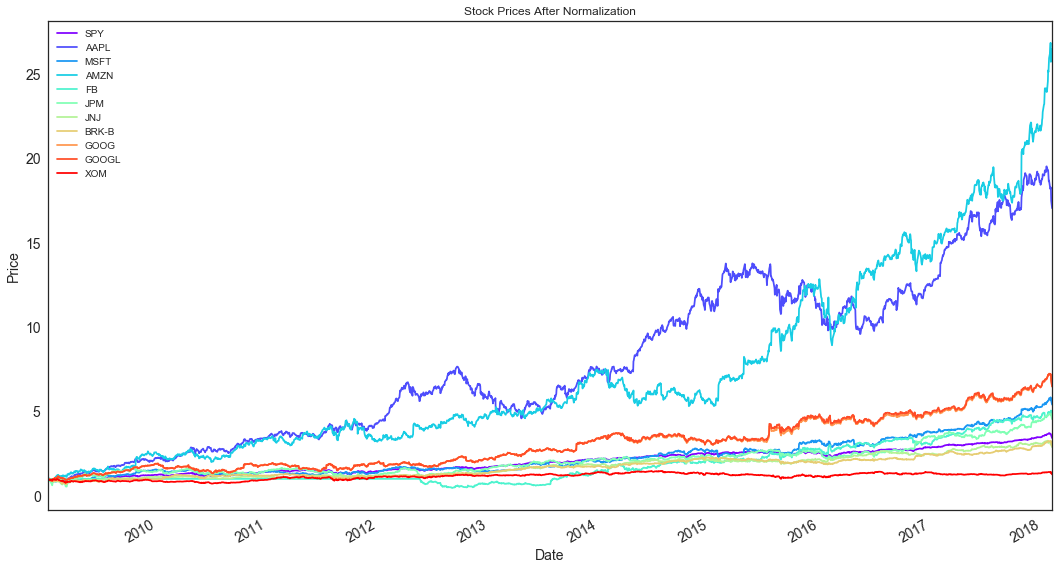

SPY       77.145294
AAPL       9.146649
MSFT      16.291746
AMZN      54.060001
FB        38.230000
JPM       23.996763
JNJ       45.395554
BRK-B     66.980003
GOOG     162.965073
GOOGL    164.189194
XOM       62.383865
Name: 2009-01-05 00:00:00, dtype: float64


In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def symbol_to_path(symbol):
    # Return CSV file path given ticker symbol
    return os.path.join("Dataset/{}.csv".format(str(symbol)))



def get_data(symbols, dates):
    df = pd.DataFrame(index = dates)
    if 'SPY' not in symbols: # add SPY for reference, if absent
        symbols.insert(0,'SPY') 
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates = True, usecols = ['Date', 'Adj Close'], na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp)

        # Drop dates SPY did not trade
        if symbol == 'SPY':
            df = df.dropna(subset=['SPY'])
        df[symbol] = pd.to_numeric(df[symbol], errors = 'coerce')
    return df



def plot_data(df, title):
    
    # Plot stock prices
    ax = df.plot(title='Stock Prices After Normalization', fontsize=14,figsize = [18,10], colormap='rainbow')
    ax.set_xlabel('Date',fontsize=14)
    ax.set_ylabel('Price',fontsize=14)
    plt.show()
    
    
def plot_selected(df, columns, start_index, end_index):
    '''Plot the desire columns over desire dates'''
    plot_data(df.loc[start_index:end_index, columns], title)
    df = df.loc[start_index:end_index, columns]

    
    
def normalize_data(df):
    return df/df.iloc[0,:]



def plot_selected_normalize(df, columns, start_index, end_index):
    
    # Normalize stock prices
    df = normalize_data(df)
    plot_data(df.loc[start_index:end_index,columns], title='Stock Prices After Normalization')
    df = df.loc[start_index: end_index, columns]
    

    
def test_run():
    
    # Define a date range
    dates = pd.date_range('2009-01-05', '2018-02-14')
    
    # Choose stock symbol to read
    symbols = ['SPY','AAPL','MSFT','AMZN','FB','JPM','JNJ','BRK-B','GOOG','GOOGL','XOM' ]

    # Get stock data
    df = get_data(symbols, dates)
    
    # Fill in the missing values in FB
    df.fillna(method = 'backfill', inplace = True)

    # Plot them out
    plot_selected_normalize(df, symbols, dates[0], dates[-1])
    
    # Double check FB missing value problem
    print df.iloc[0,:]
    
#     print df.iloc[:]

if __name__=='__main__':
    test_run()
    

#### 2.2.4 Filling in the missing values

Since Facebook had not gone IPO before 2012, I need to use fillna funtion to solve missing values.


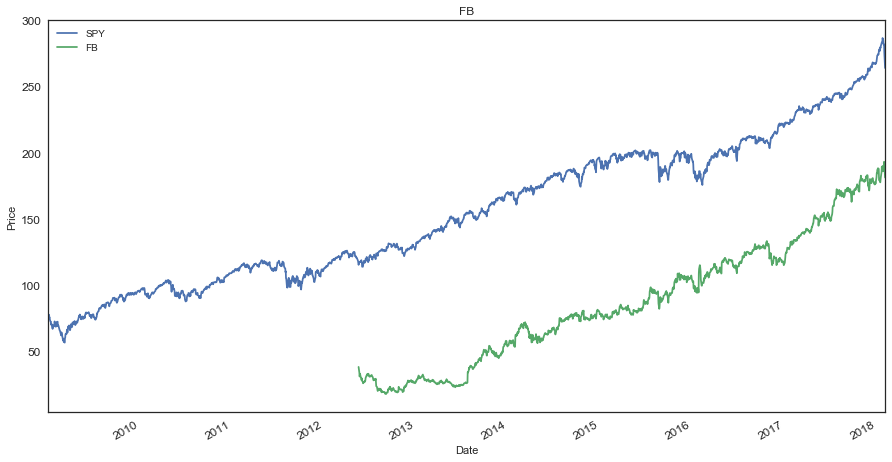

This is the stock price graph afte filled in the missing values.


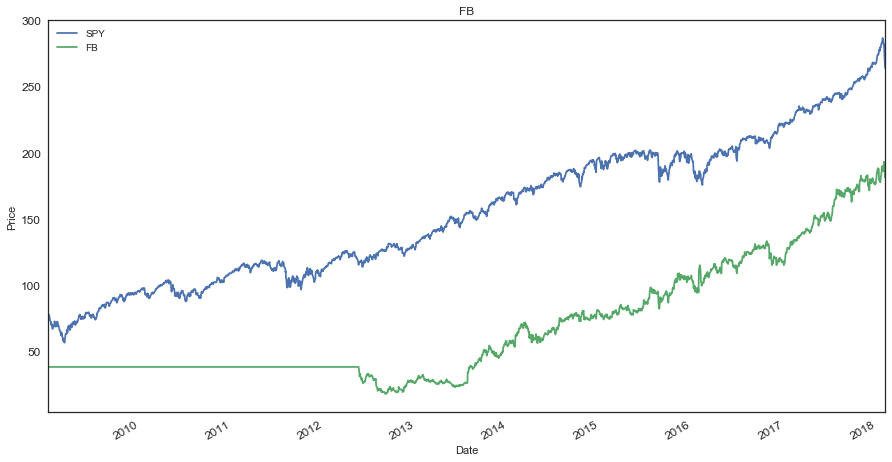

In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import get_data, plot_data,plot_selected
   
    
def plot_data(df, title = 'Stock Price'):

    # Plot stock prices
    ax = df.plot(title =title, fontsize=12, figsize = (15, 8))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

    
def test_run():
    
    # Define a date range
    dates = pd.date_range('2009-01-01','2018-02-14')
    
    # Choose stock symbol to read
    symbols = ['FB']
    
    # Get stock data
    df = get_data(symbols, dates)
    
    # Plot the data
    print 'Since Facebook had not gone IPO before 2012, I need to use fillna funtion to solve missing values.'
    plot_data(df, title='FB')
    
    
    # Fillin backward
    df.fillna(method = 'backfill', inplace = True)
    
    # Plot the data again
    print 'This is the stock price graph afte filled in the missing values.'
    plot_data(df, title = 'FB')
    

if __name__=='__main__':
    test_run()

#### 2.2.5 Daily Returns

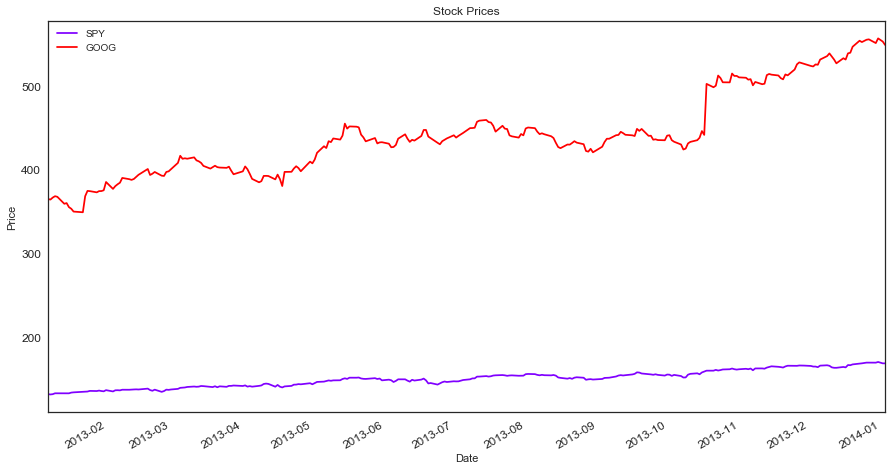

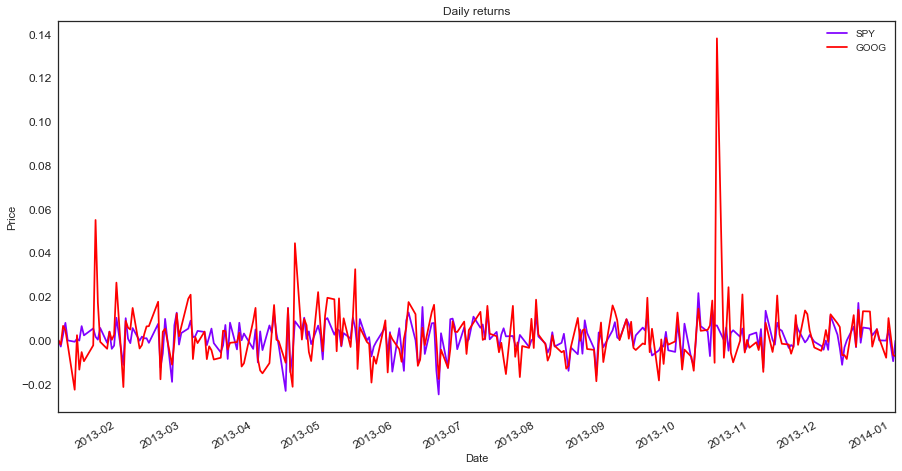

In [513]:
def plot_data(df, title = 'Stock Prices'):
    # Plot stock prices
    ax = df.plot(title =title, fontsize=12, figsize = (15, 8), colormap='rainbow')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()


def test_run():
    # Read data
    dates = pd.date_range('2013-01-05', '2014-01-05')  # one month only
    symbols = ['SPY','GOOG']
    df = get_data(symbols, dates)
    plot_data(df)

    # Compute daily returns
    daily_returns = compute_daily_returns(df)
    plot_data(daily_returns, title="Daily returns")


if __name__ == "__main__":
    test_run()


### 2.2.6 Histograms between stocks

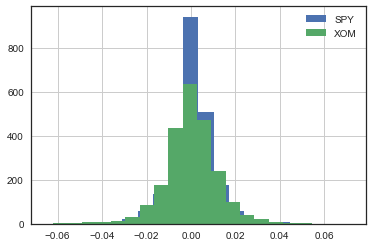

In [502]:
def plot_data(df, title = 'Stock Prices'):
    # Plot stock prices
    ax = df.plot(title =title, fontsize=12, figsize = (15, 8))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()



def test_run():

    # Step1: read two stocks
    dates = pd.date_range('2009-01-05','2018-02-14')
    symbols = ['SPY', 'XOM']
    df = get_data(symbols, dates)
    
    # Step2: Compute daily returns
    daily_returns = compute_daily_returns(df)

    # Step3: Plot two histograms on the same chart
    daily_returns['SPY'].hist(bins=20,label='SPY')
    daily_returns['XOM'].hist(bins=20, label='XOM')
    plt.legend(loc='upper right')
    plt.show()
    
    
if __name__=='__main__':
    test_run()
    

### 2.2.7 Correlations among Stocks

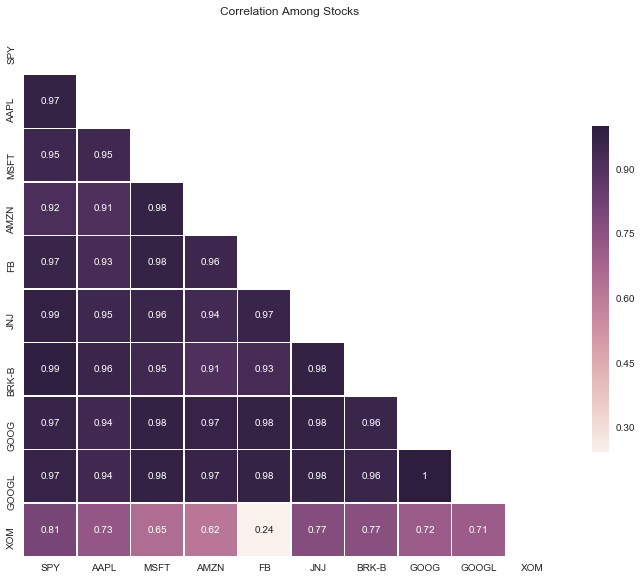

In [521]:

def test_run():
    
    # Define a date range
    dates = pd.date_range('2009-01-05', '2018-02-14')
    
    # Choose stock symbol to read
    symbols = ['SPY','AAPL','MSFT','AMZN','FB','JPM','JNJ','BRK-B','GOOG','GOOGL','XOM' ]

    # Get stock data
    df = get_data(symbols, dates)
    
    # calculate correlation matrix
    correlation = df.corr()

    # Get half of the matrix
    half = np.zeros_like(correlation, dtype=np.bool)
    half[np.triu_indices_from(half)] = True
    # plot correlation matrix
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(correlation, mask=half, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
    ax.set_title('Correlation Among Stocks ');

if __name__=='__main__':
    test_run()
    

### 2.2.8 Beta and Alpha

In [57]:

# def test_run():
    
#     # Step1: Read data
#     dates = pd.date_range('2012-01-01', '2014-01-01')
#     symbols = ['SPY', 'GOOG', 'AMZN']
#     df = get_data(symbols, dates)
    
#     # Step2: Compute daily returns
#     daily_returns = compute_daily_returns(df)
    
#     # Step3: Scatterplot SPY vs GOOG
#     daily_returns.plot(kind='scatter', x='SPY',title='SPY vs GOOG', y='GOOG', figsize=[8,4])
#     beta_GOOG, alpha_GOOG = np.polyfit(daily_returns['SPY'], daily_returns['GOOG'],1)
#     print 'beta_GOOG=',beta_GOOG
#     print 'alpha_GOOD=', alpha_GOOG
#     plt.plot(daily_returns['SPY'], beta_GOOG*daily_returns['SPY']+alpha_GOOG, '-', color='r')
#     plt.show()
    
#     # Step4: Scatterplot SPY vs AMZN
#     daily_returns.plot(kind='scatter',title='SPY vs AMZN', x='SPY', y='AMZN',figsize=[8,4])
#     beta_AMZN, alpha_AMZN = np.polyfit(daily_returns['SPY'],daily_returns['AMZN'],1)
#     print 'beta_AMZN=', beta_AMZN
#     print 'alpha_AMZN=',alpha_AMZN
#     plt.plot(daily_returns['SPY'], beta_AMZN*daily_returns['SPY'] +alpha_AMZN, '-', color='r')
#     plt.show()

#     # Step5: Find correlation coefficient
#     print daily_returns.corr(method='pearson')
    
# if __name__=='__main__':
#     test_run()


### 3.2.1 Linear Regression
 - Reference: http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/
    - Greatly thanks this author

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.999444397824
Score on testing data
regressor.score(X_testFold, y_testFold): 0.90
Mean squared error:  1.33679657961
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.998095002001
Score on testing data
regressor.score(X_testFold, y_testFold): 0.93
Mean squared error:  1.81692837646
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  0.998272667295
Score on testing data
regressor.score(X_testFold, y_testFold): 0.88
Mean squared error:  5.69663879303
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.996017932581
Score on testing data
regressor.score(X_testFold, y_testFold): 0.93
Mean squared error:  4.96649085808
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.997035232069
Score on testing data
regressor.score(X_testFold, y_testFold): 0.98
Mean squared error:  1.39476851977
1368
Score on training fold 5

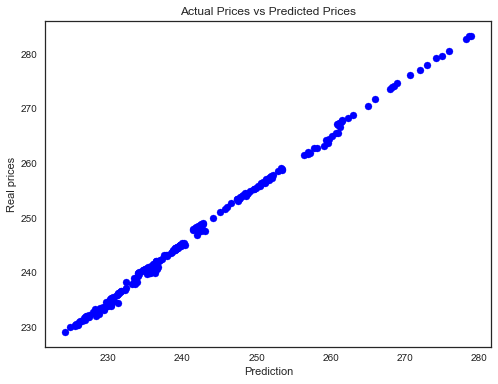

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  7.1611574295e-12
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.96832635982e-11
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  0.0770737693371
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.999906740818
Score on testing data
regressor.score(X_testFold, y_testFold): 0.67
Mean squared error:  19.2671160443
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.990197511648
Score on testing data
regressor.score(X_testFold, y_testFold): -1.46
Mean squared error:  177.574948736
1368
Score on training fold 5
regressor.score(X_trai

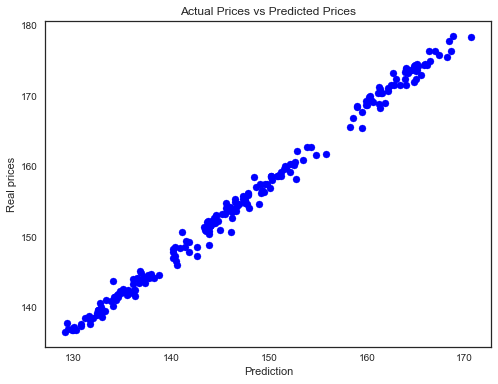

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  4.30407180501e-25
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  9.71700931235e-26
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.08180283855e-27
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  3.55856196893e-27
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  4.02829214882e-27
1368
Score on training fold 5
regressor.score(X_trainFolds, y_tr

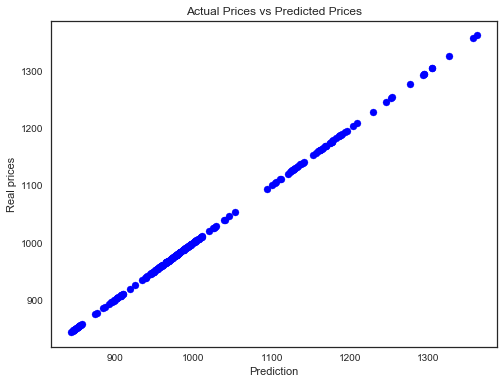

1436
143
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.61970609889e-25
286
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  5.19697742273e-25
429
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  2.97617847783e-23
572
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.30834575947e-20
715
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.76526375401e-20
858
Score on training fold 5
regressor.score(X_trainFolds, y_trai

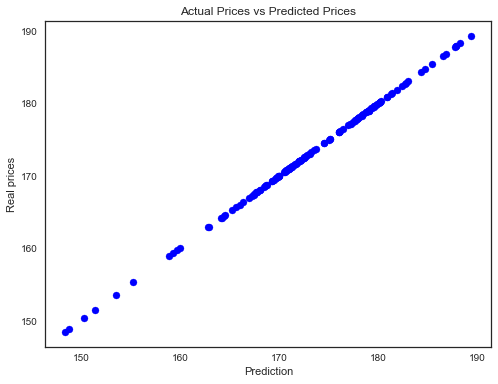

2285
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.999990244056
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  0.0153483144781
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.999868778168
Score on testing data
regressor.score(X_testFold, y_testFold): 0.99
Mean squared error:  0.118308866691
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  0.998848039312
Score on testing data
regressor.score(X_testFold, y_testFold): 0.93
Mean squared error:  0.987333974733
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.991700361867
Score on testing data
regressor.score(X_testFold, y_testFold): 0.79
Mean squared error:  4.69876433071
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.980836254974
Score on testing data
regressor.score(X_testFold, y_testFold): 0.12
Mean squared error:  5.25368841877
1368
Score on training fo

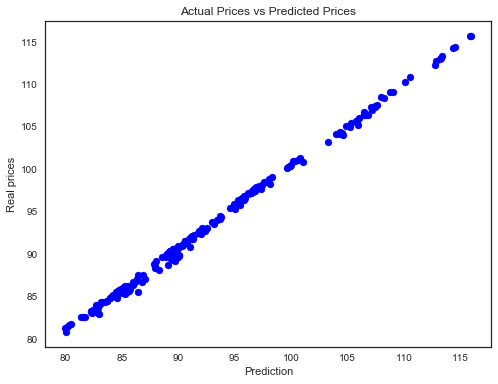

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.63781911892e-15
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.31820510272e-22
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  6.08342044663e-22
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  9.63266059345e-22
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.54728746979e-19
1368
Score on training fold 5
regressor.score(X_trainFolds, y_tr

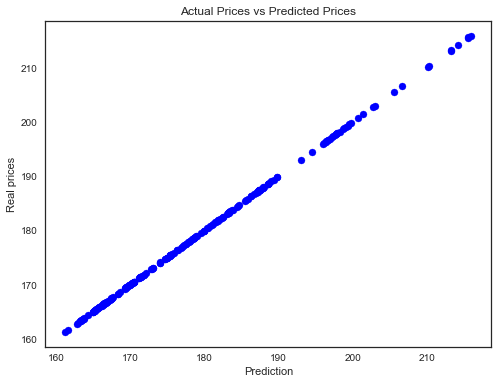

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.991120120627
Score on testing data
regressor.score(X_testFold, y_testFold): 0.56
Mean squared error:  1.47090674396
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.970862627345
Score on testing data
regressor.score(X_testFold, y_testFold): 0.24
Mean squared error:  4.05392472484
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  0.940468111124
Score on testing data
regressor.score(X_testFold, y_testFold): -0.85
Mean squared error:  6.41308680134
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.919620124912
Score on testing data
regressor.score(X_testFold, y_testFold): 0.96
Mean squared error:  1.8298898285
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.975752555623
Score on testing data
regressor.score(X_testFold, y_testFold): 0.91
Mean squared error:  1.73582869474
1368
Score on training fold 5

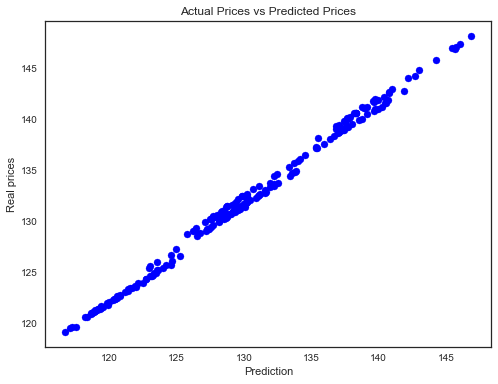

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.98663732469e-16
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  3.16000302841e-27
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.34086614989e-26
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  3.96566145817e-26
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  2.80699368109e-26
1368
Score on training fold 5
regressor.score(X_trainFolds, y_tr

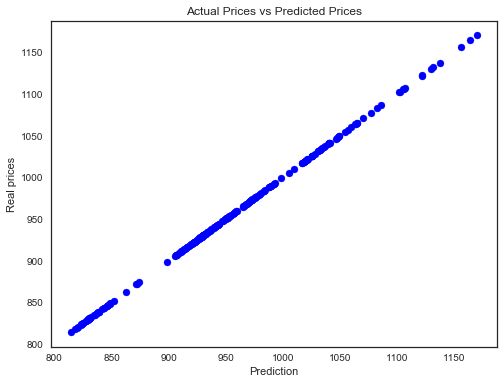

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  2.14103762409e-16
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  6.7790605508e-27
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  4.56207644416e-27
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.75935303744e-26
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  1.0
Score on testing data
regressor.score(X_testFold, y_testFold): 1.00
Mean squared error:  1.37360492001e-26
1368
Score on training fold 5
regressor.score(X_trainFolds, y_tra

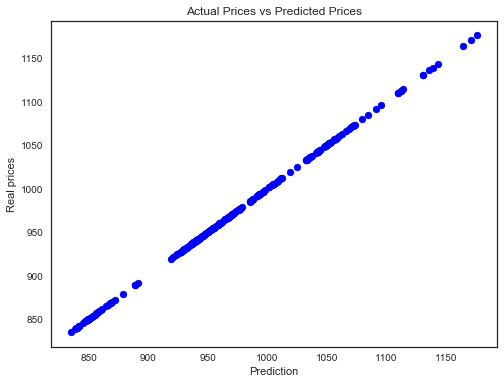

2286
228
Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.992272310727
Score on testing data
regressor.score(X_testFold, y_testFold): 0.86
Mean squared error:  1.20058222827
456
Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.986269535734
Score on testing data
regressor.score(X_testFold, y_testFold): 0.52
Mean squared error:  10.411483319
684
Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  0.973677143947
Score on testing data
regressor.score(X_testFold, y_testFold): 0.66
Mean squared error:  4.48553813844
912
Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.97786478616
Score on testing data
regressor.score(X_testFold, y_testFold): -0.55
Mean squared error:  4.20410618265
1140
Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.983839864212
Score on testing data
regressor.score(X_testFold, y_testFold): 0.75
Mean squared error:  5.82751651135
1368
Score on training fold 5


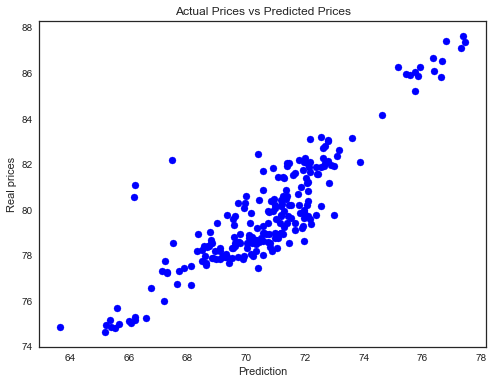

In [2]:
# import sys
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline 
# from sklearn.cross_validation import train_test_split
# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error
# from helper import symbol_to_path, get_data


def Linear_Regression_Model(symbol):
    df = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])
    # drop nan damit!!!
    df = df.dropna()
    
    # Make sure data is numeric values
    for col in df.columns:        
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Slicing data from 2009 to 2018
    df = df['2009-01-05':'2018-02-01']
    
    # Get total number of data 
    total = df['Adj Close'].count()
    print total

    # 
    num_fold = 10
    size_fold = total // num_fold
    accuracies = np.zeros(num_fold-1)
    
    # 
    for i in range(2, num_fold+1):
        
        # Build split point
        split = (i-1)/float(i)
        
        #
        X = df.iloc[:(size_fold*i), :-2].join(df.iloc[:(size_fold*i), -1]) # Add feature 'Volume' to training features
        y = df.iloc[:(size_fold*i), -2]
        #
        index = int(np.floor(X.shape[0] * split))
        print index
        
        # Slicing traing set
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        # Create linear regression model
        regressor = linear_model.LinearRegression()
        
        # Train the model using the training sets
        regressor.fit(X_trainFolds, y_trainFolds)
        
        # Query
        regressor.predict(X_testFold)
        
#       Feb14Pred = regressor.predict()
        
        # Accuracies
        accuracies[i-2] = regressor.score(X_testFold, y_testFold)
        print "Score on training fold %d" % (i-2)
        print "regressor.score(X_trainFolds, y_trainFolds): ", regressor.score(X_trainFolds, y_trainFolds)
        print "Score on testing data"
        print "regressor.score(X_testFold, y_testFold): %.2f" % accuracies[i-2]
        print "Mean squared error: ", mean_squared_error(y_testFold, regressor.predict(X_testFold))
    print 'Average accuracy for %s:' % symbol, accuracies.mean()

    # Plot outputs
    plt.figure(figsize=(8,6))
    plt.title("Actual Prices vs Predicted Prices")
    plt.xlabel("Prediction")
    plt.ylabel("Real prices")
    plt.scatter(regressor.predict(X_testFold), y_testFold, color='blue')
    plt.show()
    

def main():
    symbols = ['SPY', 'AAPL','AMZN','FB','JPM','BRK-B','JNJ','GOOG','GOOGL','XOM'] 
    for s in symbols:
        Linear_Regression_Model(s)
    
if __name__ == "__main__":
    main()

### 3.2.2 KNN



Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.504770923609
Score on testing data
regressor.score(X_testFold, y_testFold): -2.67
Mean squared error:  1234.93191075


Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.547322104531
Score on testing data
regressor.score(X_testFold, y_testFold): -37.12
Mean squared error:  4051.16108651


Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  0.526744160235
Score on testing data
regressor.score(X_testFold, y_testFold): -6.16
Mean squared error:  4459.21942521


Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.513267337495
Score on testing data
regressor.score(X_testFold, y_testFold): -8.18
Mean squared error:  4409.83714589


Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.528739453708
Score on testing data
regressor.score(X_testFold, y_testFold): -10.36
Mean squared error:  4441.3763064


Score on training fold 5
regressor.sc

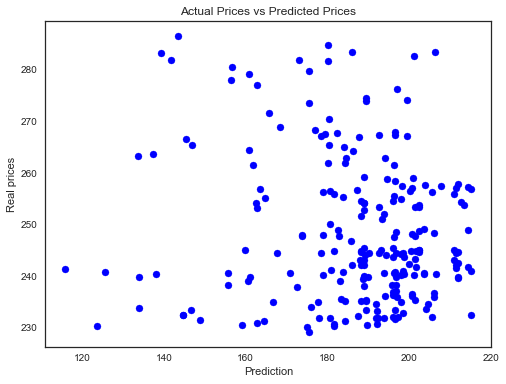

In [61]:
# import pandas as pd
# import numpy as np
# import time
# import matplotlib.pyplot as plt
# %matplotlib inline 
# from sklearn.cross_validation import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# from helper import symbol_to_path



def KNN_Model(symbol):
    
    df = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])
    total = df['Adj Close'].count()
    
    # Slicing data from 2009 to 2018
    df = df['2009-01-05':'2018-02-01']
    
    num_fold = 10
    size_fold = total // num_fold
    accuracies = np.zeros(num_fold-1)
    
    for i in range(2, num_fold+1):
        print '\n'
        split = (i-1)/float(i)
        X = df.iloc[:(size_fold*i), :-2].join(df.iloc[:(size_fold*i), -1]) # Add feature 'Volume' to training features
        y = df.iloc[:(size_fold*i), -2]
        index = int(np.floor(X.shape[0] * split))
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        # Create linear regression model
        KNNregressor = KNeighborsRegressor()    
        
        # Train the model using the training sets
        KNNregressor.fit(X_trainFolds, y_trainFolds)
        # Query
        KNNregressor.predict(X_testFold)
        # Accuracies
        accuracies[i-2] = KNNregressor.score(X_testFold, y_testFold)
        print "Score on training fold %d" % (i-2)
        print "regressor.score(X_trainFolds, y_trainFolds): ", KNNregressor.score(X_trainFolds, y_trainFolds)
        print "Score on testing data"
        print "regressor.score(X_testFold, y_testFold): %.2f" % accuracies[i-2]
        print "Mean squared error: ", mean_squared_error(y_testFold, KNNregressor.predict(X_testFold))
    print 'Average accuracy: ', accuracies[i-2].mean()

   
    # Plot outputs
#     print "\n"
    plt.figure(figsize=(8,6))
    plt.title("Actual Prices vs Predicted Prices")
    plt.xlabel("Prediction")
    plt.ylabel("Real prices")
    plt.scatter(KNNregressor.predict(X_testFold), y_testFold, color='blue')
    plt.show()
    

def main():
    symbols = ['SPY']
    for s in symbols:
         
        KNN_Model(s)
    
if __name__ == "__main__":
    main()    
    


### With GridSearchCV



best parameter:  {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 1}
best score:  -29.0165852823


Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.504770923609
Score on testing data
regressor.score(X_testFold, y_testFold): -2.67
Mean squared error:  1234.93191075


best parameter:  {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 1}
best score:  -21.0654458719


Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.547322104531
Score on testing data
regressor.score(X_testFold, y_testFold): -37.12
Mean squared error:  4051.16108651


best parameter:  {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 1}
best score:  -37.6797394067


Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  0.526744160235
Score on testing data
regressor.score(X_testFold, y_testFold): -6.16
Mean squared error:  4459.21942521


best parameter:  {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 1}
best score:  -43.283907819


Sc

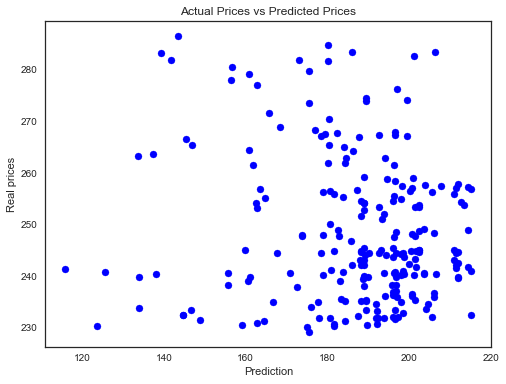

In [3]:
# import pandas as pd
# import numpy as np
# import time
# import matplotlib.pyplot as plt
# %matplotlib inline 
# from sklearn.cross_validation import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# from helper import symbol_to_path
# from sklearn.grid_search import GridSearchCV



def knn_Parameters(knn, X, y):

    # parameters for gridsearchCV
    k = [1,5,10,15,20,25,30]
    leaves = [1,5,10,15,20,25,30]
    weights = ['uniform', 'distance']
    parameters = {'n_neighbors': k, 'leaf_size': leaves, 'weights': weights}
    
    # Implement GridSearchCV
    knn = GridSearchCV(knn, parameters, cv=10)
    knn.fit(X, y)
    
    print "best parameter: ", knn.best_params_
    print "best score: ", knn.best_score_
    print "\n"
    
    return knn




def KNN_Model(symbol):
    
    df = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])
    total = df['Adj Close'].count()
    
    # Slicing data from 2009 to 2018
    df = df['2009-01-05':'2018-02-01']
    
    num_fold = 10
    size_fold = total // num_fold
    accuracies = np.zeros(num_fold-1)
    
    
    for i in range(2, num_fold+1):
        print '\n'
        split = (i-1)/float(i)
        X = df.iloc[:(size_fold*i), :-2].join(df.iloc[:(size_fold*i), -1]) # Add feature 'Volume' to training features
        y = df.iloc[:(size_fold*i), -2]
        index = int(np.floor(X.shape[0] * split))
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        # Perform GridSearchCV on each fold
        knn = KNeighborsRegressor()    
        knn_Parameters(knn, X_trainFolds, y_trainFolds)
        
        # Create linear regression model
        KNNregressor = KNeighborsRegressor()    
        
        # Train the model using the training sets
        KNNregressor.fit(X_trainFolds, y_trainFolds)
        # Query
        KNNregressor.predict(X_testFold)
        # Accuracies
        accuracies[i-2] = KNNregressor.score(X_testFold, y_testFold)
        print "Score on training fold %d" % (i-2)
        print "regressor.score(X_trainFolds, y_trainFolds): ", KNNregressor.score(X_trainFolds, y_trainFolds)
        print "Score on testing data"
        print "regressor.score(X_testFold, y_testFold): %.2f" % accuracies[i-2]
        print "Mean squared error: ", mean_squared_error(y_testFold, KNNregressor.predict(X_testFold))
        

        
    print 'Average accuracy: ', accuracies[i-2].mean()

   
    # Plot outputs
#     print "\n"
    plt.figure(figsize=(8,6))
    plt.title("Actual Prices vs Predicted Prices")
    plt.xlabel("Prediction")
    plt.ylabel("Real prices")
    plt.scatter(KNNregressor.predict(X_testFold), y_testFold, color='blue')
    plt.show()
    

def main():
    symbols = ['SPY']
    for s in symbols:
         
        KNN_Model(s)
    
if __name__ == "__main__":
    main()    
    


### 3.3.4 Support Vector Regression



Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.383379215175
Score on testing data
regressor.score(X_testFold, y_testFold): -4.84
Mean squared error:  543.285139818


Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.0458394192322
Score on testing data
regressor.score(X_testFold, y_testFold): -21.67
Mean squared error:  2899.16952058


Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  -0.0420743809351
Score on testing data
regressor.score(X_testFold, y_testFold): -7.81
Mean squared error:  1376.49709894


Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.0593799948487
Score on testing data
regressor.score(X_testFold, y_testFold): -3.58
Mean squared error:  354.871308624


Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.00633170626218
Score on testing data
regressor.score(X_testFold, y_testFold): -12.81
Mean squared error:  1304.54465339


Score on training fold 5
regre

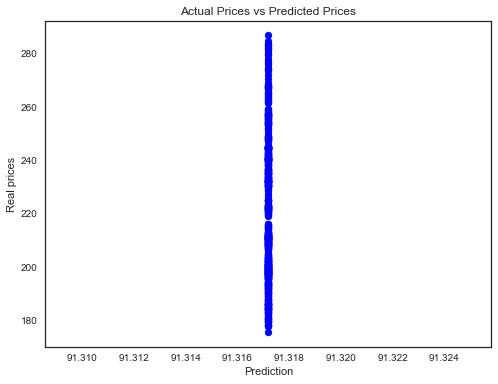

In [63]:
# import pandas as pd
# import numpy as np
# import time
# import matplotlib.pyplot as plt
# %matplotlib inline 
# from sklearn.cross_validation import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# from helper import symbol_to_path



def SVR_Model(symbol):
    
    df = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])
    total = df['Adj Close'].count()
    
    num_fold = 10
    size_fold = total // num_fold
    accuracies = np.zeros(num_fold-1)
    
    for i in range(2, num_fold+1):
        print '\n'
        split = (i-1)/float(i)
        X = df.iloc[:(size_fold*i), :-2].join(df.iloc[:(size_fold*i), -1]) # Add feature 'Volume' to training features
        y = df.iloc[:(size_fold*i), -2]
        index = int(np.floor(X.shape[0] * split))
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        # Create linear regression model
        SVRregressor = SVR()
        
        # Train the model using the training sets
        SVRregressor.fit(X_trainFolds, y_trainFolds)
        # Query
        SVRregressor.predict(X_testFold)
        # Accuracies
        accuracies[i-2] = SVRregressor.score(X_testFold, y_testFold)
        print "Score on training fold %d" % (i-2)
        print "regressor.score(X_trainFolds, y_trainFolds): ", SVRregressor.score(X_trainFolds, y_trainFolds)
        print "Score on testing data"
        print "regressor.score(X_testFold, y_testFold): %.2f" % accuracies[i-2]
        print "Mean squared error: ", mean_squared_error(y_testFold, SVRregressor.predict(X_testFold))
    print 'Average accuracy: ', accuracies[i-2].mean()

   
    # Plot outputs
#     print "\n"
    plt.figure(figsize=(8,6))
    plt.title("Actual Prices vs Predicted Prices")
    plt.xlabel("Prediction")
    plt.ylabel("Real prices")
    plt.scatter(SVRregressor.predict(X_testFold), y_testFold, color='blue')
    plt.show()
    

def main():
    symbols = ['SPY']
    for s in symbols:
         
        SVR_Model(s)
    
if __name__ == "__main__":
    main()    
    


### SVR with GridSearchCV

In [ ]:

def SVR_Parameters(svr, X, y):

    # parameters for gridsearchCV
    
    epsilon = [0.1, 0.2, 0.3]
    kernel = ['linear','rbf','poly',]
    
    parameters = {'epsilon': epsilon, 'kernel': kernel}
    
    # Implement GridSearchCV
    svr = GridSearchCV(svr, parameters, cv=10)
    svr.fit(X, y)
    
    print "best parameter: ", svr.best_params_
    print "best score: ", svr.best_score_
    print "\n"
    
    return svr


def SVR_Model(symbol):
    
    df = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'])
    total = df['Adj Close'].count()
    
    num_fold = 10
    size_fold = total // num_fold
    accuracies = np.zeros(num_fold-1)
    
    for i in range(2, num_fold+1):
        print '\n'
        split = (i-1)/float(i)
        X = df.iloc[:(size_fold*i), :-2].join(df.iloc[:(size_fold*i), -1]) # Add feature 'Volume' to training features
        y = df.iloc[:(size_fold*i), -2]
        index = int(np.floor(X.shape[0] * split))
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        # Create linear regression model
        SVRregressor = SVR()
        
        # Train the model using the training sets
        SVRregressor.fit(X_trainFolds, y_trainFolds)
        # Query
        SVRregressor.predict(X_testFold)
        # Accuracies
        accuracies[i-2] = SVRregressor.score(X_testFold, y_testFold)
        print "Score on training fold %d" % (i-2)
        print "regressor.score(X_trainFolds, y_trainFolds): ", SVRregressor.score(X_trainFolds, y_trainFolds)
        print "Score on testing data"
        print "regressor.score(X_testFold, y_testFold): %.2f" % accuracies[i-2]
        print "Mean squared error: ", mean_squared_error(y_testFold, SVRregressor.predict(X_testFold))
    
    # Perform GridSearchCV on each fold
    svr = SVR()    
    SVR_Parameters(svr, X_trainFolds, y_trainFolds)
        
    print 'Average accuracy: ', accuracies[i-2].mean()

   
    # Plot outputs
#     print "\n"
    plt.figure(figsize=(8,6))
    plt.title("Actual Prices vs Predicted Prices")
    plt.xlabel("Prediction")
    plt.ylabel("Real prices")
    plt.scatter(SVRregressor.predict(X_testFold), y_testFold, color='blue')
    plt.show()
    

def main():
    symbols = ['SPY']
    for s in symbols:
         
        SVR_Model(s)
    
if __name__ == "__main__":
    main()    
    




Score on training fold 0
regressor.score(X_trainFolds, y_trainFolds):  0.383379215175
Score on testing data
regressor.score(X_testFold, y_testFold): -4.84
Mean squared error:  543.285139818


Score on training fold 1
regressor.score(X_trainFolds, y_trainFolds):  0.0458394192322
Score on testing data
regressor.score(X_testFold, y_testFold): -21.67
Mean squared error:  2899.16952058


Score on training fold 2
regressor.score(X_trainFolds, y_trainFolds):  -0.0420743809351
Score on testing data
regressor.score(X_testFold, y_testFold): -7.81
Mean squared error:  1376.49709894


Score on training fold 3
regressor.score(X_trainFolds, y_trainFolds):  0.0593799948487
Score on testing data
regressor.score(X_testFold, y_testFold): -3.58
Mean squared error:  354.871308624


Score on training fold 4
regressor.score(X_trainFolds, y_trainFolds):  0.00633170626218
Score on testing data
regressor.score(X_testFold, y_testFold): -12.81
Mean squared error:  1304.54465339


Score on training fold 5
regre